## Problems

**1.Predicting Boston Housing Prices.** The file `BostonHousing.csv` contains information collected by the US Bureau of the Census concerning housing in the area of Boston, Massachusetts. The dataset includes information on 506 census housing tracts in the Boston area. The goal is to predict the median house price in new tracts based on information such as crime rate, pollution, and number of rooms. The dataset contains 13 predictors, and the outcome variable is the median house price (MEDV). The following describes each of the predictors and the outcome
variable:

    CRIM: Per capita crime rate by town
    ZN: Proportion of residential land zonedfor lots over 25,000 ft squared
    INDUS: Proportion of nonretail business acres per town
    CHAS: Charles River dummy variable (=1 if tract bounds river; =0 otherwise)
    NOX: Nitric oxide concentration (parts per 10 million)
    RM: Average number of rooms per dwelling
    AGE: Proportion of owner-occupied units built prior to 1940
    DIS: Weighted distances to five Boston employment centers
    RAD: Index of accessibility to radial highways
    TAX: Full-value property-tax rate per $10,000
    PTRATIO: Pupil/teacher ratio by town
    LSTAT: Percentage lower status of the population
    MEDV: Median value of owner-occupied

**a.** Why should the data be partitioned into training and validation sets? What will the training set be used for? What will the validation set be used for?

When we use the same data both to develop the model and to assess its performance, we introduce an "optimism" bias. This is because when we choose the model that works best with the data, this model's superior performance comes from two sources:

- A superior model
- Chance aspects of the data that happen to match the chosen model better than they match other models

The latter is a particularly serious problem with techniques (such as trees and neural nets) that do not impose linear or other structure on the data, and thus end up overfitting it.

To address the overfitting problem, we simply divide (partition) our data and develop our model using only one of the partitions. After we have a model, we try it out on another partition and see how it performs, which we can measure in several ways. In a classification model, we can count the proportion of held-back records that were misclassified. In a prediction model, we can measure the residuals (prediction errors) between the predicted values and the actual values. This evaluation approach in effect mimics the deployment scenario, where our model is applied to data that it hasn't "seen."

**Training Partition**: the training partition, typically the largest partition, contains the data used to build the various models we are examining. The same training partition is generally used to develop multiple models.

**Validation Partition**: the validation partition (sometimes called the test partition) is used to assess the predictive performance of each model so that you can compare models and choose the best one.

**b.** Fit a multiple linear regression model to the median house price (MEDV) as a function of CRIM, CHAS, and RM. Write the equation for predicting the median house price from the predictors in the model.

For the above predictors, we will estimate the coefficients of the regression formula from the data using a method called *ordinary least squares* (OLS). This method finds values $\hat{\beta}_0$, $\hat{\beta}_1$, $\hat{\beta}_2$, ..., $\hat{\beta}_p$, where $\hat{\beta_i}$ is the parameter for the predictor *i*, that minimize the sum of squared deviations between the actual outcome values ($Y$) and their predicted values based on that model ($\hat{Y}$).

To predict the value of the outcome variable for a record with predictor values $x_1$, $x_2$, ..., $x_p$, we use the equation:

<p>
    <center>
        $\hat{Y} = \hat{\beta}_0 + \hat{\beta}_1 x_1 + \hat{\beta}_2 x_2 + ... + \hat{\beta}_p x_p$
    </center>
</p>

One very rough rule of thumb is to have a number of records *n* larger than *5(p + 2)*, where *p* is the number of predictors. Since we have 3 predictors, we need at least *5(3 + 2) = 25* records. We have 506 records, so this is not a concern.

Let's estimate the predictors (using all data):

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm

from dmutils import adjusted_r2_score, AIC_score
from dmutils import exhaustive_search, backward_elimination
from dmutils import forward_selection, stepwise_selection
from dmutils import regression_summary
from dmutils import lift_chart, gains_chart

In [2]:
# load housing data
housing_df = pd.read_csv("../datasets/BostonHousing.csv")
housing_df

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,LSTAT,MEDV,CAT. MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0,0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6,0
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7,1
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4,1
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273,21.0,9.67,22.4,0
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273,21.0,9.08,20.6,0
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273,21.0,5.64,23.9,0
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273,21.0,6.48,22.0,0


In [3]:
# select predictors
predictors = ["CRIM", "CHAS", "RM"]
outcome = "MEDV"

# partition data
X = housing_df[predictors]
y = housing_df[outcome]

housing_lmr = LinearRegression()
housing_lmr.fit(X, y)

# print coefficients
print(pd.DataFrame({'Predictor': X.columns,
                    'coefficient': housing_lmr.coef_}))
# print intercept
print('\nIntercept: ', housing_lmr.intercept_)
# print performance measures (training data)
regression_summary(y, housing_lmr.predict(X))

  Predictor  coefficient
0      CRIM    -0.260724
1      CHAS     3.763037
2        RM     8.278180

Intercept:  -28.810682506359118

Regression statistics

                      Mean Error (ME) : -0.0000
       Root Mean Squared Error (RMSE) : 6.1453
            Mean Absolute Error (MAE) : 4.1782
          Mean Percentage Error (MPE) : -7.3835
Mean Absolute Percentage Error (MAPE) : 22.9616


Therefore, we can write the equation for predicting the median house price as:

<p>
    <center>
        $\hat{MEDV} = -28.81 - 0.26 x_{CRIM} + 3.76 x_{CHAS} + 8.27 x_{RM}$
    </center>
</p>

**c.** Using the estimated regression model, what median house price is predicted for a tract in the Boston area that does not bound the Charles River, has a crime rate of 0.1, and where the average number of rooms per house is 6?

In [4]:
# the example of a data frame home to be scored using our regression model

new_data = pd.DataFrame({"CHAS": [0], "CRIM": [0.1], "RM": [6]})

print(new_data)
print("\nPredictions: ", housing_lmr.predict(new_data))

   CHAS  CRIM  RM
0     0   0.1   6

Predictions:  [21.23470007]


Thus the predicted MEDV is \\$21.23 (in \\$1000s) for this house. Since there is no data that is exactly the same as the example given above we are not able to calculate the prediction error (residual).

**d.** Reduce the number of predictors:

    i. Which predictors are likely to be measuring the same thing among the 13 predictors? Discuss the
    relationships among INDUS, NOX, and TAX.

    ii. Compute the correlation table for the 12 numerical predictors and search for highly correlated pairs.
    These have potential redundancy and can cause multicollinearity. Choose which ones to remove based on this
    table.

Let's plot the correlation matrix among variables and check for possible multicollinearity (Multicollinearity is the presence of two or more predictors sharing the same linear relationship with the outcome variable).

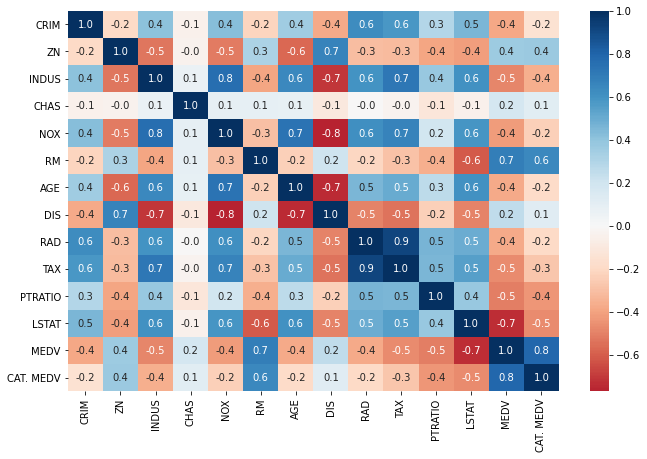

In [5]:
# simple heatmap of correlations (without values)
corr = housing_df.corr()

# include information about values
# (example demonstrate how to control the size of the plot)
fig, ax = plt.subplots()
fig.set_size_inches(11, 7)
sns.heatmap(corr, annot=True, fmt=".1f", cmap="RdBu", center=0, ax=ax)
plt.show()

**i.** We can see from the above correlation matrix that the correlation between TAX, INDUS and NOX variables are strong, and positive, correlations (knowing the value of one of these variables gives a hint about the others):

- TAX and INDUS: 0.7
- TAX and NOX: 0.7
- NOX and INDUS: 0.8

**ii.** Other correlations are:

- DIS and INDUS: -0.7
- DIS and TAX: -0.7
- DIS and AGE: -0.7
- DIS and NOX: -0.7

These correlation suggest that the weighted distances to five Boston employment centers are inversely proportional to the proportion of nonretail business acres per town, proportion of owner-occupied units built prior to 1940 (old houses), nitric oxide concentration (pollution, parts per 10 million), and full-value property-tax rate per \\$10,000.

Therefore, these would be good candidates to be removed from the predictor lists as a way to reduce/remove multicollinearity problem.

    iii. Use three subset selection algorithms: backward, forward, and stepwise) to reduce the remaining
    predictors. Compute the validation performance for each of the three selected models. Compare RMSE, MAPE,
    and mean error, as well as histograms of the errors. Finally, describe the best model.

In [6]:
# select predictors (all variables)
predictors = ["CRIM", "ZN", "INDUS", "CHAS", "NOX",
              "RM", "AGE", "DIS", "RAD", "TAX", "PTRATIO", "LSTAT"]

# partition data, 40% test set
X = housing_df[predictors]
y = housing_df[outcome]
train_X, valid_X, train_y, valid_y = train_test_split(X, y, 
                                                      test_size=0.4,
                                                      random_state=1)

- Exhaustive search:

In [7]:
def train_model(variables):
    model = LinearRegression()
    model.fit(train_X[list(variables)], train_y)
    return model

def score_model(model, variables):
    pred_y = model.predict(train_X[list(variables)])
    # we negate as score is optimized to be as low as possible
    return -adjusted_r2_score(train_y, pred_y, model)

all_variables = train_X.columns
results = exhaustive_search(all_variables, train_model, score_model)

data = []
for result in results:
    model = result["model"]
    variables = list(result["variables"])
    AIC = AIC_score(train_y, model.predict(train_X[variables]), model)

    d = {"n": result["n"], "r2adj": -result["score"], "AIC": AIC}
    d.update({var: var in result["variables"] for var in sorted(all_variables)})
    data.append(d)

pd.DataFrame(data, columns=("n", "r2adj", "AIC") + tuple(sorted(all_variables)))

,n,r2adj,AIC,AGE,CHAS,CRIM,DIS,INDUS,LSTAT,NOX,PTRATIO,RAD,RM,TAX,ZN
0,1,0.572980,1934.913465,False,False,False,False,False,True,False,False,False,False,False,False
1,2,0.651683,1874.178531,False,False,False,False,False,True,False,False,False,True,False,False
2,3,0.687239,1842.541774,False,False,False,False,False,True,False,True,False,True,False,False
3,4,0.693208,1837.687606,False,True,False,False,False,True,False,True,False,True,False,False
4,5,0.708318,1823.366167,False,False,False,True,False,True,True,True,False,True,False,False
5,6,0.714863,1817.467502,False,False,False,True,False,True,True,True,False,True,False,True
6,7,0.721032,1811.815660,False,True,False,True,False,True,True,True,False,True,False,True
7,8,0.723443,1810.156279,False,True,True,True,False,True,True,True,False,True,False,True
8,9,0.727136,1807.050098,False,False,True,True,False,True,True,True,True,True,True,True
9,10,0.731108,1803.571740,False,True,True,True,False,True,True,True,True,True,True,True


- Backward Selection

In [8]:
def train_model(variables):
    model = LinearRegression()
    model.fit(train_X[variables], train_y)
    return model

def score_model(model, variables):
    return AIC_score(train_y, model.predict(train_X[variables]), model)


all_variables = train_X.columns
best_model, best_variables = backward_elimination(all_variables, train_model, score_model,
                                                  verbose=True)
print(best_variables)
regression_summary(valid_y, best_model.predict(valid_X[best_variables]))

Variables: CRIM, ZN, INDUS, CHAS, NOX, RM, AGE, DIS, RAD, TAX, PTRATIO, LSTAT
Start: score=1807.23
Step: score=1805.30, remove=AGE
Step: score=1803.57, remove=INDUS
Step: score=1803.57, remove=None
['CRIM', 'ZN', 'CHAS', 'NOX', 'RM', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'LSTAT']

Regression statistics

                      Mean Error (ME) : -0.0393
       Root Mean Squared Error (RMSE) : 5.0771
            Mean Absolute Error (MAE) : 3.5746
          Mean Percentage Error (MPE) : -5.1561
Mean Absolute Percentage Error (MAPE) : 16.9733


Percentage of datapoints with a residual in [-5, 5]:  0.7684729064039408


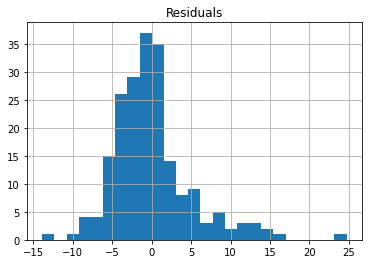

In [9]:
all_residuals = valid_y - best_model.predict(valid_X[best_variables])

# Determine the percentage of datapoints with a residual in [-5, 5] = approx. 75%
print("Percentage of datapoints with a residual in [-5, 5]: ",
      len(all_residuals[(all_residuals > -5) & (all_residuals < 5)]) / len(all_residuals))

pd.DataFrame({"Residuals": all_residuals}).hist(bins=25)
plt.show()

- Forward Selection

In [10]:
# The initial model is the constant model - this requires special handling
# in train_model and score_model
def train_model(variables):
    if len(variables) == 0:
        return None
    model = LinearRegression()
    model.fit(train_X[variables], train_y)
    return model

def score_model(model, variables):
    if len(variables) == 0:
        return AIC_score(train_y, [train_y.mean()] * len(train_y), model, df=1)
    return AIC_score(train_y, model.predict(train_X[variables]), model)

best_model, best_variables = forward_selection(train_X.columns, train_model,
                                               score_model, verbose=True)
print(best_variables)
regression_summary(valid_y, best_model.predict(valid_X[best_variables]))

Variables: CRIM, ZN, INDUS, CHAS, NOX, RM, AGE, DIS, RAD, TAX, PTRATIO, LSTAT
Start: score=2191.75, constant
Step: score=1934.91, add LSTAT
Step: score=1874.18, add RM
Step: score=1842.54, add PTRATIO
Step: score=1837.69, add CHAS
Step: score=1835.00, add NOX
Step: score=1817.90, add DIS
Step: score=1811.82, add ZN
Step: score=1810.16, add CRIM
Step: score=1808.01, add RAD
Step: score=1803.57, add TAX
Step: score=1803.57, add None
['LSTAT', 'RM', 'PTRATIO', 'CHAS', 'NOX', 'DIS', 'ZN', 'CRIM', 'RAD', 'TAX']

Regression statistics

                      Mean Error (ME) : -0.0393
       Root Mean Squared Error (RMSE) : 5.0771
            Mean Absolute Error (MAE) : 3.5746
          Mean Percentage Error (MPE) : -5.1561
Mean Absolute Percentage Error (MAPE) : 16.9733


Percentage of datapoints with a residual in [-5, 5]:  0.7684729064039408


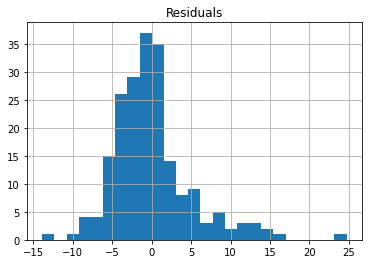

In [11]:
all_residuals = valid_y - best_model.predict(valid_X[best_variables])

# Determine the percentage of datapoints with a residual in [-5, 5] = approx. 75%
print("Percentage of datapoints with a residual in [-5, 5]: ",
      len(all_residuals[(all_residuals > -5) & (all_residuals < 5)]) / len(all_residuals))

pd.DataFrame({"Residuals": all_residuals}).hist(bins=25)
plt.show()

- Stepwise Selection

In [12]:
best_model, best_variables = stepwise_selection(train_X.columns, train_model,
                                                score_model, verbose=True)
print(best_variables)
regression_summary(valid_y, best_model.predict(valid_X[best_variables]))

Variables: CRIM, ZN, INDUS, CHAS, NOX, RM, AGE, DIS, RAD, TAX, PTRATIO, LSTAT
Start: score=2191.75, constant
Step: score=1934.91, add LSTAT
Step: score=1874.18, add RM
Step: score=1842.54, add PTRATIO
Step: score=1837.69, add CHAS
Step: score=1835.00, add NOX
Step: score=1817.90, add DIS
Step: score=1811.82, add ZN
Step: score=1810.16, add CRIM
Step: score=1808.01, add RAD
Step: score=1803.57, add TAX
Step: score=1803.57, unchanged None
['LSTAT', 'RM', 'PTRATIO', 'CHAS', 'NOX', 'DIS', 'ZN', 'CRIM', 'RAD', 'TAX']

Regression statistics

                      Mean Error (ME) : -0.0393
       Root Mean Squared Error (RMSE) : 5.0771
            Mean Absolute Error (MAE) : 3.5746
          Mean Percentage Error (MPE) : -5.1561
Mean Absolute Percentage Error (MAPE) : 16.9733


Percentage of datapoints with a residual in [-5, 5]:  0.7684729064039408


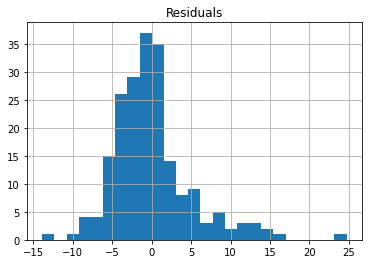

In [13]:
all_residuals = valid_y - best_model.predict(valid_X[best_variables])

# Determine the percentage of datapoints with a residual in [-5, 5] = approx. 75%
print("Percentage of datapoints with a residual in [-5, 5]: ",
      len(all_residuals[(all_residuals > -5) & (all_residuals < 5)]) / len(all_residuals))

pd.DataFrame({"Residuals": all_residuals}).hist(bins=25)
plt.show()

The chosen ten-predictor models from backward, forward and stepwise selection are identical to the best eight-predictor model chosen by the exhaustive search. The variables are:

- CHAS;
- CRIM;
- DIS;
- LSTAT;
- NOX;
- PTRATIO;
- RAD;
- RM;
- TAX;
- ZN;

In this example, forward selection, backward selection and stepwise regression end up with this same ten-predictor model. This need not be the case with other datasets. Besides that, the histogram of errors are the same as the resultant models are the same for all variable selector methods.

Finally, the validation performance of the ten-predictor models is slightly better than the all-predictor model in terms of validation metrics (see below table). This happens because of the multicollinearity effect that regression coefficients suffer - there are variables in the model that have small coefficients relative to the standard deviation of the noise and also exhibit at least moderate correlation with other variables);

                       R_adj       AIC
      ten-predictor: 0.731108    1803.571740
      all-predictor: 0.729557    1807.231231

There is an even smaller model, performing only slightly worse, that is preferable from a parsimony standpoint.

**2.Predicting Software Reselling Profits.** Tayko Software is a software catalog firm that sells games and educational software. It started out as a software manufacturer and then added third-party titles to its offerings. It recently revised its collection of items in a new catalog, which it mailed out to its customers. This mailing yielded 2000 purchases. Based on these data, Tayko wants to devise a model for predicting the spending amount that a purchasing customer will yield. The file `Tayko.csv` contains information on 2000 purchases. The following table describes the variables to be used in the problem (the Excel file contains additional variables).

    FREQ: Number of transactions in the preceding year
    LAST_UPDATE: Number of days since last update to customer record
    WEB: Whether customer purchased by Web order at least once
    GENDER: Male or female
    ADDRESS_RES: Whether it is a residential address
    ADDRESS_US: Whether it is a US address
    SPENDING: Amount spent by customer in (outcome) test mailing ($)

**a.** Explore the spending amount by creating a pivot table for the categorical variables and computing the average and standard deviation of spending in each category.

In [14]:
columns=["Freq", "last_update_days_ago", "Web order", "Gender=male",
         "Address_is_res", "US", "Spending"]
selling_df = pd.read_csv("../datasets/Tayko.csv")
selling_df = selling_df[columns].copy()
selling_df = selling_df.rename(columns={"Freq": "FREQ",
                                        "last_update_days_ago": "LAST_UPDATE",
                                        "Web order": "WEB",
                                        "Gender=male": "GENDER",
                                        "Address_is_res": "ADDRESS_RES",
                                        "US": "ADDRESS_US",
                                        "Spending": "SPENDING"
                                       })
selling_df.head()

,FREQ,LAST_UPDATE,WEB,GENDER,ADDRESS_RES,ADDRESS_US,SPENDING
0,2,3662,1,0,1,1,128
1,0,2900,1,1,0,1,0
2,2,3883,0,0,0,1,127
3,1,829,0,1,0,1,0
4,1,869,0,0,0,1,0


- Web

In [15]:
selling_df[["WEB", "SPENDING"]].groupby("WEB").agg({"SPENDING": ["mean", "std"]})

SPENDING            
           mean         std
WEB                        
0     82.902439  173.417088
1    129.199531  200.463840

Web spending are higher on average compared to non-web spending;

- Gender

In [16]:
selling_df[["GENDER", "SPENDING"]].groupby("GENDER").agg({"SPENDING": ["mean", "std"]})

SPENDING           
              mean        std
GENDER                       
0       107.339642  190.83233
1        98.350810  183.02006

Male spending are higher on average compared to female spending;

- Address Residential

In [17]:
selling_df[["ADDRESS_RES", "SPENDING"]].groupby("ADDRESS_RES").agg({"SPENDING": ["mean", "std"]})

SPENDING            
                   mean         std
ADDRESS_RES                        
0            105.306162  199.521159
1             93.174208  132.204281

Non-address residential purchases spending are higher on average compared to residential addresses spending;

- Address US

In [18]:
selling_df[["ADDRESS_US", "SPENDING"]].groupby("ADDRESS_US").agg({"SPENDING": ["mean", "std"]})

SPENDING            
                  mean         std
ADDRESS_US                        
0           101.216524  174.844401
1           102.924803  189.275664

Address US purchases spending are almost the same (on average) compared to non-us addresses spending;

**b.** Explore the relationship between spending and each of the two continuous predictors by creating two scatter plots (Spending vs. Freq, and Spending vs. last_update_days_ago). Does there seem to be a linear relationship?

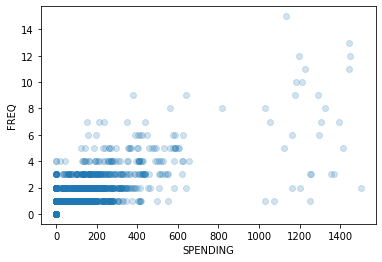

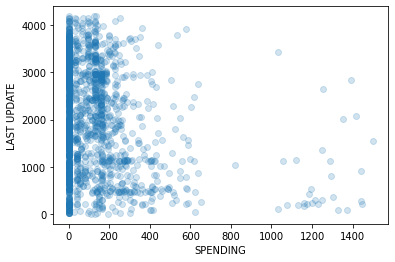

In [19]:
plt.scatter(selling_df.SPENDING, selling_df.FREQ, alpha=0.2)
plt.xlabel("SPENDING")
plt.ylabel("FREQ")
plt.show()

plt.scatter(selling_df.SPENDING, selling_df.LAST_UPDATE, alpha=0.2)
plt.xlabel("SPENDING")
plt.ylabel("LAST UPDATE")
plt.show()

The relationship between spending and frequency of purchase appears appears to be linear, such that when the frequency increases, so does the amount spent. The relationship between spending and last update seems to be less linear. Though it appears to exist a linear relationship between the two variable.

Computing the correlation matrix help us to be sure about such relationships:

In [20]:
selling_df[["FREQ", "LAST_UPDATE", "SPENDING"]].corr()

,FREQ,LAST_UPDATE,SPENDING
FREQ,1.000000,-0.348303,0.691128
LAST_UPDATE,-0.348303,1.000000,-0.256912
SPENDING,0.691128,-0.256912,1.000000


From the correlation matrix it is possible to see that both have a linear relationship, being the spending and frequency of transactions in the previous year a positive and strong correlation and the last update (number of days since last update to customer record) negatively, but no strongly, correlated with spending.

**c.** To fit a predictive model for Spending:

    i. Partition the 2000 records into training and validation sets.

In [21]:
# select predictors
predictors = ["FREQ", "LAST_UPDATE", "WEB", "GENDER",
              "ADDRESS_RES", "ADDRESS_US"]
outcome = "SPENDING"

# partition data, 40% test set
X = selling_df[predictors]
y = selling_df[outcome]
train_X, valid_X, train_y, valid_y = train_test_split(X, y, 
                                                      test_size=0.4,
                                                      random_state=1)

    ii. Run a multiple linear regression model for Spending vs. all six predictors. Give the estimated
    predictive equation.

In [22]:
selling_lmr = LinearRegression()
selling_lmr.fit(train_X, train_y)

# print coefficients
print(pd.DataFrame({'Predictor': train_X.columns,
                    'coefficient': selling_lmr.coef_}))
# print intercept
print('\nIntercept: ', selling_lmr.intercept_)
# print performance measures (training data)
regression_summary(y, selling_lmr.predict(X))

     Predictor  coefficient
0         FREQ    91.274450
1  LAST_UPDATE    -0.010374
2          WEB    18.628731
3       GENDER    -9.111366
4  ADDRESS_RES   -75.815354
5   ADDRESS_US    -4.620293

Intercept:  10.176297413561059

Regression statistics

               Mean Error (ME) : 2.8773
Root Mean Squared Error (RMSE) : 130.4020
     Mean Absolute Error (MAE) : 81.1267


Therefore, we can write the equation for predicting the selling amount as:

<p>
    <center>
        $\hat{Y}_{SPENDING} = 10.17 + 91.27 x_{FREQ} - 0.01 x_{LAST\_UPDATE} + 18.63 x_{WEB} - 9.11 x_{GENDER} - 75.81 x_{ADD\_RES} - 4.62 x_{ADD\_US}$
    </center>
</p>

    iii. Based on this model, what type of purchaser is most likely to spend a large amount of money?

Users that have a higher number of transactions in the past years, done on web, likely to be male and not purchasing for residential address. The other variables do not influence too much the model (`LAST_UPDATE` and `ADDRESS_US`).

    iv. If we used backward elimination to reduce the number of predictors, which predictor would be dropped
    first from the model?

In [23]:
def train_model(variables):
    model = LinearRegression()
    model.fit(train_X[variables], train_y)
    return model

def score_model(model, variables):
    return AIC_score(train_y, model.predict(train_X[variables]), model)


all_variables = train_X.columns
best_model, best_variables = backward_elimination(all_variables, train_model, score_model,
                                                  verbose=True)
print(best_variables)
regression_summary(valid_y, best_model.predict(valid_X[best_variables]))

Variables: FREQ, LAST_UPDATE, WEB, GENDER, ADDRESS_RES, ADDRESS_US
Start: score=15028.53
Step: score=15026.76, remove=ADDRESS_US
Step: score=15026.38, remove=GENDER
Step: score=15026.38, remove=None
['FREQ', 'LAST_UPDATE', 'WEB', 'ADDRESS_RES']

Regression statistics

               Mean Error (ME) : 6.9616
Root Mean Squared Error (RMSE) : 136.5274
     Mean Absolute Error (MAE) : 83.4472


According to the backward elimitation the first variable would be `ADDRESS_US`, followed by `GENDER`;

    v. Show how the prediction and the prediction error are computed for the first purchase in the validation
    set.

In [24]:
valid_X.iloc[0, :]

FREQ              2
LAST_UPDATE    1346
WEB               0
GENDER            1
ADDRESS_RES       1
ADDRESS_US        1
Name: 674, dtype: int64

In [25]:
valid_y.iloc[0]

0

The computation would be the following:

<p>
    <center>
        $\hat{Y}_{SPENDING} = 10.17 + 91.27 * 2 - 0.01 * 1346 + 18.63 * 0 - 9.11 * 1 - 75.81 * 1 - 4.62 * 1$
    </center>
</p>

Resulting in a value of \\$89.71. The prediction error would be calculated as follows:

<p>
    <center>
        $err = Y - \hat{Y}_{SPENDING} = 0 - 89.71 = 89.71$
    </center>
</p>


For the first 20 rows we have the following:

In [26]:
selling_lmr_pred = selling_lmr.predict(valid_X)
result = pd.DataFrame({"Predicted": selling_lmr_pred,
                       "Actual": valid_y,
                       "Residual": valid_y - selling_lmr_pred})
print(result.head(20))

       Predicted  Actual     Residual
674    89.214915       0   -89.214915
1699  202.231362     184   -18.231362
1282   49.159303       0   -49.159303
1315  824.841659    1289   464.158341
1210    0.121196       0    -0.121196
1636   86.766675       0   -86.766675
613    58.018614       0   -58.018614
447   247.428569    1255  1007.571431
1131   67.036615       0   -67.036615
808    67.825031       0   -67.825031
1496   -7.098168       0     7.098168
1468  194.814024     411   216.185976
1682  -13.480101       0    13.480101
1149  -32.457046       0    32.457046
442    61.247979       0   -61.247979
1813    4.497885     173   168.502115
654   -46.046854       0    46.046854
1264  -32.315195       0    32.315195
858    80.219048       0   -80.219048
1482   51.783900       0   -51.783900


    vi. Evaluate the predictive accuracy of the model by examining its performance on the validation set.

In [27]:
# print performance measures (validation data)
regression_summary(valid_y, selling_lmr_pred)


Regression statistics

               Mean Error (ME) : 7.1933
Root Mean Squared Error (RMSE) : 136.7397
     Mean Absolute Error (MAE) : 83.6010


    vii. Create a histogram of the model residuals. Do they appear to follow a normal distribution? How does
    this affect the predictive performance of the model?

Percentage of datapoints with a residual in [-230, 230]:  0.955


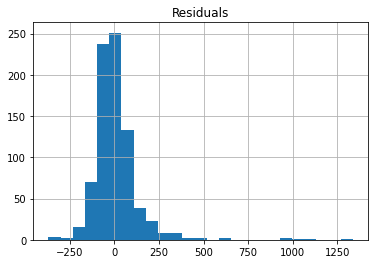

In [28]:
all_residuals = valid_y - selling_lmr.predict(valid_X)

# Determine the percentage of datapoints with a residual in [-230, 230] = approx. 95%
print("Percentage of datapoints with a residual in [-230, 230]: ",
      len(all_residuals[(all_residuals > -230) & (all_residuals < 230)]) / len(all_residuals))

pd.DataFrame({"Residuals": all_residuals}).hist(bins=25)
plt.show()

We can see from the above figure that the residuals follow a normal distribution. Then 95% of them should fall between -230 and 230. If they fall above 230 or below -230, they can be considered unusual. Besides, we can say that the predictions will be unbiased (equal to the true values on average) and will have the smallest mean squared error compared to any unbiased estimates if we make the following assumptions:

1. The **noise ε (or equivalently, Y) follows a normal distribution**.

2. The choice of predictors and their form is correct (linearity).

3. The records are independent of each other.

4. The variability in the outcome values for a given set of predictors is the same regardless of the values of the predictors (homoskedasticity).

Since the noise ε follows a normal distribution, we know that these are the best predictions possible (unbiased).

**3. Predicting Airfare on New Routes.**

The following problem takes place in the United States in the late 1990s, when many major US cities were facing issues with airport congestion, partly as a result of the 1978 deregulation of airlines. Both fares and routes were freed from regulation, and low-fare carriers such as Southwest (SW) began competing on existing routes and starting nonstop service on routes that previously lacked it. Building completely new airports is generally not feasible, but sometimes decommissioned military bases or smaller municipal airports can be reconfigured as regional or larger commercial airports. There are numerous players and interests involved in the issue (airlines, city, state and federal authorities, civic groups, the military, airport operators), and an aviation consulting firm is seeking advisory contracts with these players. The firm needs predictive models to support its consulting service. One thing the firm might want to be able to predict is fares, in the event a new airport is brought into service. The firm starts with the file `Airfares.csv`, which contains real data that were collected between Q3-1996 and Q2-1997. The variables in these data are listed below, and are believed to be important in predicting FARE. Some airport-to-airport data are available, but most data are at the city-to-city level. One question that will be of interest in the analysis is the effect that the presence or absence of Southwest has on FARE.

    S_CODE: Starting airport’s code
    S_CITY: Starting city
    E_CODE: Ending airport’s code
    E_CITY: Ending city
    COUPON: Average number of coupons (a one-coupon flight is a nonstop flight, a two-coupon flight is
            a one-stop flight, etc.) for that route 
    NEW: Number of new carriers entering that route between Q3-1996 and Q2-1997
    VACATION: Whether (Yes) or not (No) a vacation route
    SW: Whether (Yes) or not (No) Southwest Airlines serves that route
    HI: Herfindahl index: measure of market concentration
    S_INCOME: Starting city’s average personal income
    E_INCOME: Ending city’s average personal income
    S_POP: Starting city’s population
    E_POP: Ending city’s population
    SLOT: Whether or not either endpoint airport is slot-controlled (this is a measure of airport congestion)
    GATE: Whether or not either endpoint airport has gate constraints (this is another measure 
          of airport congestion)
    DISTANCE: Distance between two endpoint airports in miles
    PAX: Number of passengers on that route during period of data collection 
    FARE: Average fare on that route

**a.** Explore the numerical predictors and outcome (FARE) by creating a correlation table and examining some scatterplots between FARE and those predictors. What seems to be the best single predictor of FARE?

In [29]:
airfares_df = pd.read_csv("../datasets/Airfares.csv")
airfares_df.head()

,S_CODE,S_CITY,E_CODE,E_CITY,COUPON,NEW,VACATION,SW,HI,S_INCOME,E_INCOME,S_POP,E_POP,SLOT,GATE,DISTANCE,PAX,FARE
0,*,Dallas/Fort Worth TX,*,Amarillo TX,1.00,3,No,Yes,5291.99,28637.0,21112.0,3036732,205711,Free,Free,312,7864,64.11
1,*,Atlanta GA,*,Baltimore/Wash Intl MD,1.06,3,No,No,5419.16,26993.0,29838.0,3532657,7145897,Free,Free,576,8820,174.47
2,*,Boston MA,*,Baltimore/Wash Intl MD,1.06,3,No,No,9185.28,30124.0,29838.0,5787293,7145897,Free,Free,364,6452,207.76
3,ORD,Chicago IL,*,Baltimore/Wash Intl MD,1.06,3,No,Yes,2657.35,29260.0,29838.0,7830332,7145897,Controlled,Free,612,25144,85.47
4,MDW,Chicago IL,*,Baltimore/Wash Intl MD,1.06,3,No,Yes,2657.35,29260.0,29838.0,7830332,7145897,Free,Free,612,25144,85.47


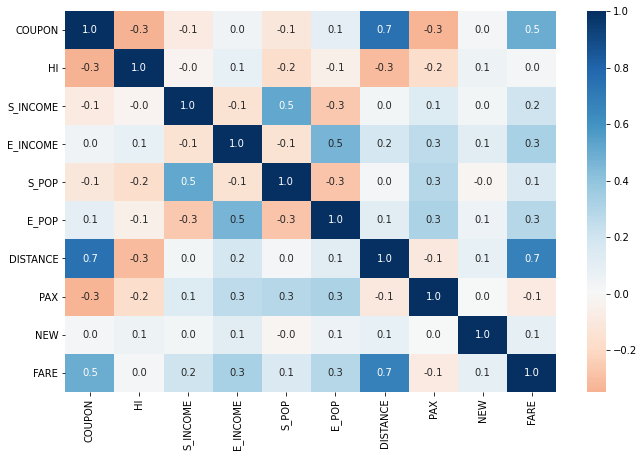

In [30]:
# numerical predictors
columns = ["COUPON", "HI", "S_INCOME", "E_INCOME", "S_POP", "E_POP",
           "DISTANCE", "PAX", "NEW", "FARE"]
corr = airfares_df[columns].corr()

# include information about values
fig, ax = plt.subplots()
fig.set_size_inches(11, 7)
sns.heatmap(corr, annot=True, fmt=".1f", cmap="RdBu", center=0, ax=ax)
plt.show()

Looking at the correlation matrix, the `COUPON` and `DISTANCE` exhibit interesting linear relationships with `FARE` - approx. 0.5 and 0.7, respectively. We can also see from the matrix that `DISTANCE` has the strongest correlation and therefore is the best single predictor of `FARE`. The `S_INCOME`, `E_INCOME` and `E_POP` also showed a positive correlation, though these correlations are not strong. Let's plot these variables:

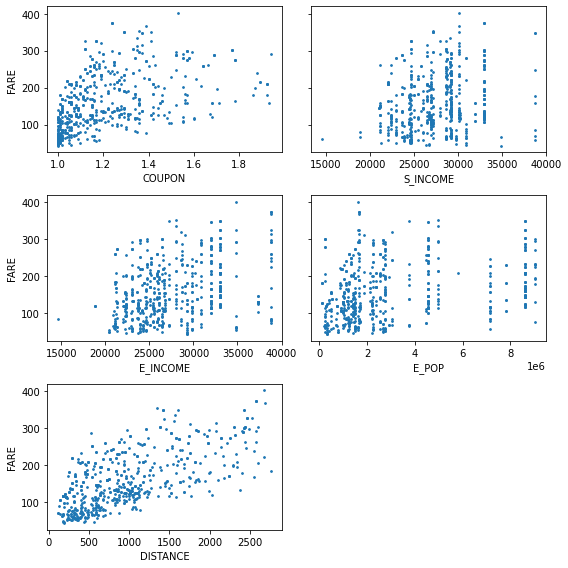

In [31]:
columns = ["COUPON", "S_INCOME", "E_INCOME", "E_POP", "DISTANCE", "FARE"]
plot_df = airfares_df[columns]

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(8, 8),
                         tight_layout=True, sharey=True)
fig.delaxes(axes[2, 1])

axes[0][0].scatter(plot_df.COUPON, plot_df.FARE, s=3)
axes[0][1].scatter(plot_df.S_INCOME, plot_df.FARE, s=3)
axes[1][0].scatter(plot_df.E_INCOME, plot_df.FARE, s=3)
axes[1][1].scatter(plot_df.E_POP, plot_df.FARE, s=3)
axes[2][0].scatter(plot_df.DISTANCE, plot_df.FARE, s=3)

axes[0][0].set_ylabel("FARE")
axes[0][0].set_xlabel("COUPON")
axes[0][1].set_xlabel("S_INCOME")
axes[1][0].set_ylabel("FARE")
axes[1][0].set_xlabel("E_INCOME")
axes[1][1].set_xlabel("E_POP")
axes[2][0].set_ylabel("FARE")
axes[2][0].set_xlabel("DISTANCE")

plt.show()

**b.** Explore the categorical predictors (excluding the first four) by computing the percentage of flights in each category. Create a pivot table with the average fare in each category. Which categorical predictor seems best for predicting FARE?


- Vacation

In [32]:
airfares_df[["VACATION", "FARE"]].groupby("VACATION").agg({"FARE": ["mean", "std"]})

FARE           
                mean        std
VACATION                       
No        173.552500  81.086891
Yes       125.980882  44.102634

- SW

In [33]:
airfares_df[["SW", "FARE"]].groupby("SW").agg({"FARE": ["mean", "std"]})

FARE           
           mean        std
SW                        
No   188.182793  70.558360
Yes   98.382268  44.795629

- Slot

In [34]:
airfares_df[["SLOT", "FARE"]].groupby("SLOT").agg({"FARE": ["mean", "std"]})

FARE           
                  mean        std
SLOT                             
Controlled  186.059396  70.852198
Free        150.825680  75.758051

- GATE

In [35]:
airfares_df[["GATE", "FARE"]].groupby("GATE").agg({"FARE": ["mean", "std"]})

FARE           
                   mean        std
GATE                              
Constrained  193.129032  64.910693
Free         153.095953  76.511829

All categorical values present different means for each of its categorical values (True/False), though two of them appear to have more predictive power over the others (`VACATION` and `SW`). The `SW` mean/std for each group seem to be particular interesting as a predictor of `FARE`. 

In [36]:
# categorical predictors
columns = ["VACATION", "SW", "SLOT", "GATE", "FARE"]
corr = airfares_df[columns].copy()

# tranforming categorical predictors to bool
# another way to do this is using pd.get_dummies(airfares_df[columns])
corr["VACATION"] = corr.VACATION.map({"Yes": 1, "No": 0})
corr["SW"] = corr.SW.map({"Yes": 1, "No": 0})
corr["SLOT"] = corr.SLOT.map({"Controlled": 1, "Free": 0})
corr["GATE"] = corr.GATE.map({"Constrained": 1, "Free": 0})
corr = corr.corr()

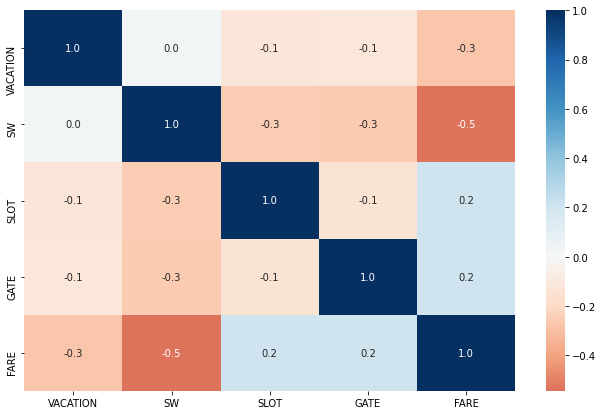

In [37]:
# include information about values
fig, ax = plt.subplots()
fig.set_size_inches(11, 7)
sns.heatmap(corr, annot=True, fmt=".1f", cmap="RdBu", center=0, ax=ax)
plt.show()

**c.** Find a model for predicting the average fare on a new route:

    i. Convert categorical variables into dummy variables. Then, partition the data into training and
       validation  sets. The model will be fit to the training data and evaluated on the validation set.


In [38]:
# categorical predictors
columns = ["VACATION", "SW", "SLOT", "GATE"]
data_df = airfares_df[columns].copy()

# tranforming categorical predictors to bool
# another way to do this is using pd.get_dummies(airfares_df[columns])
data_df["VACATION"] = data_df.VACATION.map({"Yes": 1, "No": 0})
data_df["SW"] = data_df.SW.map({"Yes": 1, "No": 0})
data_df["SLOT"] = data_df.SLOT.map({"Controlled": 1, "Free": 0})
data_df["GATE"] = data_df.GATE.map({"Constrained": 1, "Free": 0})

# numerical predictors
columns = ["COUPON", "HI", "S_INCOME", "E_INCOME", "S_POP", "E_POP",
           "DISTANCE", "PAX", "NEW", "FARE"]

data_df = data_df.join(airfares_df[columns]).copy()
data_df

,VACATION,SW,SLOT,GATE,COUPON,HI,S_INCOME,E_INCOME,S_POP,E_POP,DISTANCE,PAX,NEW,FARE
0,0,1,0,0,1.00,5291.99,28637.0,21112.0,3036732,205711,312,7864,3,64.11
1,0,0,0,0,1.06,5419.16,26993.0,29838.0,3532657,7145897,576,8820,3,174.47
2,0,0,0,0,1.06,9185.28,30124.0,29838.0,5787293,7145897,364,6452,3,207.76
3,0,1,1,0,1.06,2657.35,29260.0,29838.0,7830332,7145897,612,25144,3,85.47
4,0,1,0,0,1.06,2657.35,29260.0,29838.0,7830332,7145897,612,25144,3,85.47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
633,1,0,1,0,1.08,2216.70,32991.0,37375.0,8621121,991717,1030,34324,3,129.63
634,1,0,0,1,1.08,2216.70,32991.0,37375.0,8621121,991717,1030,34324,0,129.63
635,1,0,0,0,1.17,6797.80,27994.0,37375.0,4948339,991717,960,6016,3,124.87
636,1,0,0,0,1.28,5566.43,31981.0,37375.0,4549784,991717,858,4877,3,129.62


In [39]:
predictors = data_df.columns[:-1]
outcome = data_df.columns[-1]

# partition data, 40% test set
X = data_df[predictors]
y = data_df[outcome]
train_X, valid_X, train_y, valid_y = train_test_split(X, y, 
                                                      test_size=0.4,
                                                      random_state=1)

    ii. Use stepwise regression to reduce the number of predictors. You can ignore the first four predictors
        (S_CODE, S_CITY, E_CODE, E_CITY). Report the estimated model selected.

In [40]:
# The initial model is the constant model - this requires special handling
# in train_model and score_model
def train_model(variables):
    if len(variables) == 0:
        return None
    model = LinearRegression()
    model.fit(train_X[variables], train_y)
    return model

def score_model(model, variables):
    if len(variables) == 0:
        return AIC_score(train_y, [train_y.mean()] * len(train_y), model, df=1)
    return AIC_score(train_y, model.predict(train_X[variables]), model)

best_model, best_variables = stepwise_selection(train_X.columns, train_model,
                                                score_model, verbose=True)
print(best_variables)
regression_summary(valid_y, best_model.predict(valid_X[best_variables]))

Variables: VACATION, SW, SLOT, GATE, COUPON, HI, S_INCOME, E_INCOME, S_POP, E_POP, DISTANCE, PAX, NEW
Start: score=4379.42, constant
Step: score=4149.88, add DISTANCE
Step: score=4025.89, add SW
Step: score=3913.59, add VACATION
Step: score=3890.27, add HI
Step: score=3873.33, add GATE
Step: score=3852.81, add SLOT
Step: score=3850.30, add PAX
Step: score=3844.58, add E_POP
Step: score=3826.43, add S_POP
Step: score=3821.88, add E_INCOME
Step: score=3821.88, unchanged None
['DISTANCE', 'SW', 'VACATION', 'HI', 'GATE', 'SLOT', 'PAX', 'E_POP', 'S_POP', 'E_INCOME']

Regression statistics

                      Mean Error (ME) : -1.8591
       Root Mean Squared Error (RMSE) : 36.1129
            Mean Absolute Error (MAE) : 28.5252
          Mean Percentage Error (MPE) : -6.7084
Mean Absolute Percentage Error (MAPE) : 21.7198


    iii. Repeat (ii) using exhaustive search instead of stepwise regression. Compare the resulting best
         model to the one you obtained in (ii) in terms of the predictors that are in the model.

In [41]:
def train_model(variables):
    model = LinearRegression()
    model.fit(train_X[list(variables)], train_y)
    return model

def score_model(model, variables):
    pred_y = model.predict(train_X[list(variables)])
    # we negate as score is optimized to be as low as possible
    return -adjusted_r2_score(train_y, pred_y, model)

all_variables = train_X.columns
results = exhaustive_search(all_variables, train_model, score_model)

data = []
for result in results:
    model = result["model"]
    variables = list(result["variables"])
    AIC = AIC_score(train_y, model.predict(train_X[variables]), model)

    d = {"n": result["n"], "r2adj": -result["score"], "AIC": AIC}
    d.update({var: var in result["variables"] for var in sorted(all_variables)})
    data.append(d)

pd.DataFrame(data, columns=("n", "r2adj", "AIC") + tuple(sorted(all_variables)))

,n,r2adj,AIC,COUPON,DISTANCE,E_INCOME,E_POP,GATE,HI,NEW,PAX,SLOT,SW,S_INCOME,S_POP,VACATION
0,1,0.453107,4149.881509,False,True,False,False,False,False,False,False,False,False,False,False,False
1,2,0.605715,4025.892420,False,True,False,False,False,False,False,False,False,True,False,False,False
2,3,0.706909,3913.585125,False,True,False,False,False,False,False,False,False,True,False,False,True
3,4,0.724977,3890.268211,False,True,False,False,False,True,False,False,False,True,False,False,True
4,5,0.737584,3873.328296,False,True,False,False,True,True,False,False,False,True,False,False,True
5,6,0.751947,3852.808698,False,True,False,False,True,True,False,False,True,True,False,False,True
6,7,0.758747,3843.170960,False,True,False,True,False,True,False,True,False,True,False,True,True
7,8,0.765105,3833.945866,False,True,False,True,True,True,False,True,False,True,False,True,True
8,9,0.770266,3826.433471,False,True,False,True,True,True,False,True,True,True,False,True,True
9,10,0.773567,3821.876901,False,True,True,True,True,True,False,True,True,True,False,True,True


The chosen ten-predictor model chosen by the exhaustive model are: `DISTANCE`, `E_INCOME`, `E_POP`, `GATE`, `HI`, `PAX`, `SLOT`, `SW`, `S_POP`, `VACATION`. The result of stepwise regression is identical to the best ten-predictor model chosen by the exhaustive model.

    iv. Compare the predictive accuracy of both models (ii) and (iii) using measures such as RMSE and
        average error and lift charts.

Once the models were the same, the following measures and graph apply to both of them. 

**Important note:**

Cumulative gains and lift charts for a continuous response are relevant only when we are searching for a set of records that gives the highest cumulative predicted values. Such charts are not relevant if we are interested in predicting the outcome value for each new record.


Regression statistics

                      Mean Error (ME) : -1.8591
       Root Mean Squared Error (RMSE) : 36.1129
            Mean Absolute Error (MAE) : 28.5252
          Mean Percentage Error (MPE) : -6.7084
Mean Absolute Percentage Error (MAPE) : 21.7198

r2adj:  0.7790766452927753


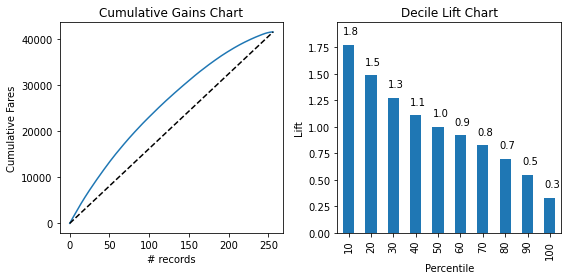

In [42]:
pred_y = pd.Series(best_model.predict(valid_X[best_variables]))

regression_summary(valid_y, pred_y)
print("\nr2adj: ", adjusted_r2_score(valid_y, pred_y, best_model))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
ax = gains_chart(pred_y.sort_values(ascending=False), ax=axes[0])
ax.set_ylabel("Cumulative Fares")
ax.set_title("Cumulative Gains Chart")

ax = lift_chart(pred_y.sort_values(ascending=False), ax=axes[1])
ax.set_ylabel("Lift")
plt.tight_layout()
plt.show()

The above figure shows a cumulative gains chart and decile lift chart based on fitting a linear regression model to the `Airfares.csv`. The charts are based on the validation data of 256 fares and routes. It can be seen that the
model's predictive performance in terms of gains is better than the baseline model (average), since its cumulative gains curve is higher than that of the baseline model.

The overall measures of predictive accuracy show the following:

                            Mean Error (ME) : $-1.8591
         Root Mean Squared Error (RMSE) : $36.1129
                  Mean Absolute Error (MAE) : $28.5252
            Mean Percentage Error (MPE) : $-6.7084
      Mean Absolute Percentage Error (MAPE) : $21.7198

Note that, in terms of the performance, this model resulted pretty good.

    v. Using model (iii), predict the average fare on a route with the following characteristics:
       COUPON = 1.202, NEW = 3, VACATION = No, SW = No, HI = 4442.141, S_INCOME = $28,760, E_INCOME = $27,664,
       S_POP = 4,557,004, E_POP = 3,195,503, SLOT = Free,
       GATE = Free, PAX = 12,782, DISTANCE = 1976 miles.


In [43]:
# the example of a data frame home to be scored using our regression model
new_data = pd.DataFrame({"VACATION": [0], "SW": [0], "SLOT": [0], "GATE": [0],
                         "COUPON": [1.202], "HI": [4442.141], "S_INCOME": [28760], "E_INCOME": [27664],
                         "S_POP": [4557004], "E_POP": [3195503], "DISTANCE": [1976], "PAX": [12782], "NEW": [3]})

# using the best variables only
print("\nPredictions: ", best_model.predict(new_data[best_variables]))
new_data[[col for col in new_data.columns if col in best_variables]]


Predictions:  [251.72153114]


,VACATION,SW,SLOT,GATE,HI,E_INCOME,S_POP,E_POP,DISTANCE,PAX
0,0,0,0,0,4442.141,27664,4557004,3195503,1976,12782


Let's compare the new data with others with similar `FARE`:

In [44]:
mask = (data_df.FARE >= 245) & (data_df.FARE <= 255)
data_df[mask]

,VACATION,SW,SLOT,GATE,COUPON,HI,S_INCOME,E_INCOME,S_POP,E_POP,DISTANCE,PAX,NEW,FARE
21,0,0,0,0,1.52,2967.59,38813.0,29838.0,1653017,7145897,2454,6417,3,246.85
39,0,0,1,1,1.12,8714.03,32991.0,25237.0,8621121,1318892,539,9305,3,250.73
40,0,0,1,1,1.12,8714.03,32991.0,25237.0,8621121,1318892,539,9305,3,250.73
41,0,0,0,1,1.12,8714.03,32991.0,25237.0,8621121,1318892,539,9305,3,250.73
84,0,0,0,1,1.22,4033.32,28637.0,26506.0,3036732,4459144,1001,6401,3,245.28
200,0,0,0,1,1.24,6166.10,24706.0,28739.0,9056076,2761118,1539,7749,3,246.10
327,0,0,0,0,1.17,5921.73,28637.0,27994.0,3036732,4948339,1314,7630,3,249.45
460,0,0,0,0,1.18,5570.80,28637.0,23903.0,3036732,2673620,1163,4596,3,252.97
465,0,0,0,1,1.30,5472.07,28739.0,23903.0,2761118,2673620,1532,3066,3,251.73
473,0,0,0,0,1.36,5492.60,26993.0,38813.0,3532657,1653017,2137,10112,3,248.49


We can say they are reasonably similar in terms of predictors, specially the important ones (e.g. `SW`, `VACATION`)

    vi. Predict the reduction in average fare on the route in (v) if Southwest decides to cover this route
        [using model (iii)].

In [45]:
# the example of a data frame home to be scored using our regression model
new_data = pd.DataFrame({"VACATION": [0], "SW": [1], "SLOT": [0], "GATE": [0],
                         "COUPON": [1.202], "HI": [4442.141], "S_INCOME": [28760], "E_INCOME": [27664],
                         "S_POP": [4557004], "E_POP": [3195503], "DISTANCE": [1976], "PAX": [12782], "NEW": [3]})

# using the best variables only
print("\nPredictions: ", best_model.predict(new_data[best_variables]))
new_data[[col for col in new_data.columns if col in best_variables]]


Predictions:  [208.69025908]


,VACATION,SW,SLOT,GATE,HI,E_INCOME,S_POP,E_POP,DISTANCE,PAX
0,0,1,0,0,4442.141,27664,4557004,3195503,1976,12782


Almost \\$50 dollars!

    vii. In reality, which of the factors will not be available for predicting the average fare
         from a new airport (i.e., before flights start operating on those routes)?
         Which ones can be estimated? How?

The variables that correlates with the number of passengers/carriers/market would be difficult to estimate before flights start operating on a specific route (`PAX`, `NEW` and `HI`). `COUPON`, `SW`, Incomes, and Populations can all be predicted with a high level of confidence since those factors are independent the proposed flight. `VACATION`, `SLOT`, and `GATE` can be predicted based on the proposed route and knowledge of the airport's policies but are highly susceptible to changes.

    viii. Select a model that includes only factors that are available before flights begin to operate
          on the new route. Use an exhaustive search to find such a model.

This means we will need to remove `PAX`, `NEW` and `HI` variables. Looking at the previous computation by the exhaustive search table, the best model would be a three-predictive model with these variables:

- DISTANCE
- SW
- VACATION

    ix. Use the model in (viii) to predict the average fare on a route with characteristics:
        COUPON = 1.202, NEW = 3, VACATION = No, SW = No, HI = 4442.141, S_INCOME = 28,760,
        E_INCOME = $27,664, S_ POP = 4,557,004, E_POP = 3,195,503, SLOT = Free,
        GATE = Free, PAX = 12,782, DISTANCE = 1976 miles.

In [46]:
predictors = ["DISTANCE", "SW", "VACATION"]
outcome = "FARE"

airfare_lmr = LinearRegression()
airfare_lmr.fit(train_X[predictors], train_y)

# the example of a data frame home to be scored using our regression model
new_data = pd.DataFrame({"VACATION": [0], "SW": [1], "SLOT": [0], "GATE": [0],
                         "COUPON": [1.202], "HI": [4442.141], "S_INCOME": [28760], "E_INCOME": [27664],
                         "S_POP": [4557004], "E_POP": [3195503], "DISTANCE": [1976], "PAX": [12782], "NEW": [3]})

# using the best variables only
print("\nPredictions: ", airfare_lmr.predict(new_data[predictors]))
new_data[[col for col in new_data.columns if col in predictors]]


Predictions:  [204.90881318]


,VACATION,SW,DISTANCE
0,0,1,1976


Not bad, \\$50 less compared to the model using ten variables.

    x. Compare the predictive accuracy of this model with model (iii). Is this model good
       enough, or is it worthwhile reevaluating the model once flights begin on the new route?


Regression statistics

                      Mean Error (ME) : -1.2464
       Root Mean Squared Error (RMSE) : 42.5705
            Mean Absolute Error (MAE) : 33.7933
          Mean Percentage Error (MPE) : -8.0557
Mean Absolute Percentage Error (MAPE) : 25.1156

r2adj:  0.7015303109350637


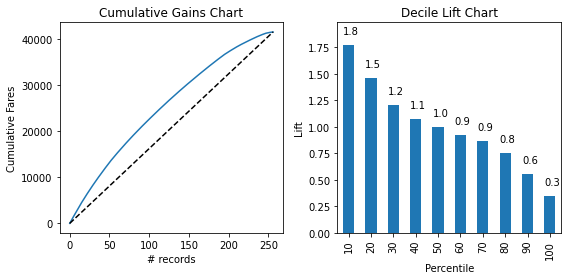

In [47]:
pred_y = pd.Series(airfare_lmr.predict(valid_X[predictors]))

regression_summary(valid_y, pred_y)
print("\nr2adj: ", adjusted_r2_score(valid_y, pred_y, airfare_lmr))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
ax = gains_chart(pred_y.sort_values(ascending=False), ax=axes[0])
ax.set_ylabel("Cumulative Fares")
ax.set_title("Cumulative Gains Chart")

ax = lift_chart(pred_y.sort_values(ascending=False), ax=axes[1])
ax.set_ylabel("Lift")
plt.tight_layout()
plt.show()

The above table shows the validation performance of the 3-predictor model as well as the gain and lift charts, which turns out to be only slightly worse than the 10-predictor model in terms of validation metrics. Since this model performs only slightly worse, it would be preferable from a **parsimony** standpoint.

**d.** In competitive industries, a new entrant with a novel business plan can have a disruptive effect on existing firms. If a new entrant's business model is sustainable, other players are forced to respond by changing their business practices. If the goal of the analysis was to evaluate the effect of Southwest Airlines' presence on the airline industry rather than predicting fares on new routes, how would the analysis be different? Describe technical and conceptual aspects.


In particular, the difference in the objective behind fitting a regression model would be:

    Explaining or quantifying the average effect of inputs on an outcome (explanatory or descriptive task,
    respectively) rather than predicting the outcome value for new records, given their input values
    (predictive task)
    
In that scenario, the data would be treated as a random sample from a larger population of interest. The regression model estimated from this sample would be an attempt to capture the *average* relationship in the larger population when comparing the group of data that has `SW` on new routes and those that has not. This model is then used in decision-making to generate statements such as "the `SW` presence ($X_{SW}$) is associated with an average increase of \\$50 dollars in the average fair ($Y$), all other factors ($X_{VACATION}$, $X_{GATE}$, ..., $X_{POPULATION}$) being equal." If $X_{SW}$ is known to *cause* $Y$, then such a statement indicates actionable policy changes - this is called explanatory modeling. When the causal structure is unknown, then this model quantifies the degree of *association* between the inputs and outcome variable, and the approach is called descriptive modeling.

Besides that, in explanatory and descriptive modeling, where the focus is on modeling the average record, we try to fit the best model to the data in an attempt to learn about the underlying relationship in the population. In contrast, in predictive modeling (data mining), the goal is to find a regression model that best predicts new individual records. A regression model that fits the existing data too well is not likely to perform well with new data.

**4. Predicting Prices of Used Cars.** The file `ToyotaCorolla.csv` contains data on used cars (Toyota Corolla) on sale during late summer of 2004 in the Netherlands. It has 1,436 records containing details on 38 attributes, including Price, Age, Kilometers, HP, and other specifications. The goal is to predict the price of a used Toyota Corolla based on its specifications.

Split the data into training (50%), validation (30%), and test (20%) datasets. Run a multiple linear regression with the outcome variable `Price` and predictor variables `Age_08_04`, `KM`, `Fuel_Type`, `HP`, `Automatic`, `Doors`, `Quarterly_Tax`, `Mfr_Guarantee`, `Guarantee_Period`, `Airco`, `Automatic_airco`, `CD_Player`, `Powered_Windows`, `Sport_Model`, and `Tow_Bar`.

**a.** What appear to be the three or four most important car specifications for predicting the car’s price?

Some considerations before start this exercise. The importance of a variable in a regression models depends of some attributes of the model. In summary, they are:

- Larger coefficients don't necessarily identify more important predictor variables. Why? Regression coefficients use different scales, so we can't compare them directly. However, if we standardize/normalize the regression coefficients, so they're based on the same scale, we can compare them.

- Low p-values don't necessarily identify predictor variables that are practically important. Why? A very low p-value can reflect properties other than importance, such as a very precise estimate and a large sample size

- Combining these two statistics we can determine variable importance. Therefore, let's use the `statsmodels` here. Let's also normalize the data.

From [here](https://blog.minitab.com/en/adventures-in-statistics-2/how-to-identify-the-most-important-predictor-variables-in-regression-models).


In [48]:
car_df = pd.read_csv('../datasets/ToyotaCorolla.csv')

# Fuel_Type - a categorical variable with 3 different values
# We will use only N-1 dummy variables when we have categorical variables
car_df.Fuel_Type = car_df.Fuel_Type.astype("category")
car_df = pd.get_dummies(car_df,
                        columns=["Fuel_Type"], prefix_sep="_",
                        drop_first=False)

predictors = ['Age_08_04', 'KM', 'Fuel_Type_CNG', 'Fuel_Type_Diesel', 'HP', 'Automatic',
              'Doors', 'Quarterly_Tax', 'Mfr_Guarantee', 'Guarantee_Period', 'Airco',
              'Automatic_airco', 'CD_Player', 'Powered_Windows', 'Sport_Model', 'Tow_Bar']
outcome = 'Price'

# normalizing data
scaler = MinMaxScaler()
car_df_norm = pd.DataFrame(scaler.fit_transform(car_df[predictors + [outcome]]),
                           columns=predictors + [outcome])


# partition data
# random_state is set to a defined value to get the same partitions when re-running the code
# training: 50 %
# validation: 30% => 0.5 * 0.6
# test: 20% => 0.5 * 0.4
train_data, temp = train_test_split(car_df_norm[predictors + [outcome]], test_size=0.50, random_state=1)
valid_data, test_data = train_test_split(temp, test_size=0.40, random_state=1)

print("Training:   ", train_data.shape)
print("Validation: ", valid_data.shape)
print("Test:       ", test_data.shape)

train_data.head()

Training:    (718, 17)
Validation:  (430, 17)
Test:        (288, 17)


,Age_08_04,KM,Fuel_Type_CNG,Fuel_Type_Diesel,HP,Automatic,Doors,Quarterly_Tax,Mfr_Guarantee,Guarantee_Period,Airco,Automatic_airco,CD_Player,Powered_Windows,Sport_Model,Tow_Bar,Price
780,0.759494,0.315635,0.0,0.0,0.138211,0.0,1.000000,0.189394,0.0,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.198934
1010,0.746835,0.152025,0.0,0.0,0.333333,0.0,1.000000,0.250000,1.0,0.000000,0.0,0.0,0.0,0.0,1.0,1.0,0.182948
1426,0.974684,0.127420,0.0,0.0,0.333333,1.0,0.333333,0.250000,1.0,0.272727,1.0,0.0,0.0,0.0,0.0,1.0,0.198934
1405,0.949367,0.186869,0.0,0.0,0.138211,0.0,1.000000,0.189394,1.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.120782
1282,1.000000,0.301232,0.0,0.0,0.333333,0.0,1.000000,0.250000,0.0,0.000000,0.0,0.0,0.0,1.0,1.0,0.0,0.111901


In [49]:
# run a linear regression of Price on the remaining 11 predictors in the
# training set
train_df = train_data[predictors].join(train_data[outcome])
formula = 'Price ~ ' + ' + '.join(predictors)
car_lm = sm.ols(formula=formula, data=train_df).fit()
car_lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.893
Model:                            OLS   Adj. R-squared:                  0.891
Method:                 Least Squares   F-statistic:                     366.0
Date:                Sat, 04 Sep 2021   Prob (F-statistic):               0.00
Time:                        18:28:46   Log-Likelihood:                 1225.5
No. Observations:                 718   AIC:                            -2417.
Df Residuals:                     701   BIC:                            -2339.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.3629      0.011     32.120      0.000       0.341       0.385
Age_08_04           -0.3147      0.011    -28.475      0.000      -0.336      -0.293
KM                  -0.1678      0.015    -10.983      0.000      -0.198      -0.138
Fuel_Type_CNG       -0.0699      0.018     -3.935      0.000      -0.105      -0.035
Fuel_Type_Diesel     0.0069      0.012      0.566      0.572      -0.017       0.031
HP                   0.1725      0.019      9.188      0.000       0.136       0.209
Automatic            0.0207      0.007      2.915      0.004       0.007       0.035
Doors                0.0229      0.006      4.110      0.000       0.012       0.034
Quarterly_Tax        0.1612      0.021      7.574      0.000       0.119       0.203
Mfr_Guarantee        0.0046      0.004      1.283      0.200      -0.002       0.012
Guarantee_Period     0.0906      0.019      4.689      0.000       0.053       0.129
Airco                0.0016      0.004      0.387      0.699      -0.007       0.010
Automatic_airco      0.1050      0.008     12.907      0.000       0.089       0.121
CD_Player            0.0098      0.005      2.074      0.038       0.001       0.019
Powered_Windows      0.0185      0.004      4.528      0.000       0.010       0.027
Sport_Model          0.0184      0.004      4.780      0.000       0.011       0.026
Tow_Bar             -0.0095      0.004     -2.431      0.015      -0.017      -0.002
==============================================================================
Omnibus:                      116.745   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              401.916
Skew:                           0.747   Prob(JB):                     5.31e-88
Kurtosis:                       6.347   Cond. No.                         29.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Most important variables are:

- `Age_08_04`
- `KM`
- `HP`
- `Quarterly_Tax`
- `Automatic_airco`

**b.** Using metrics you consider useful, assess the performance of the model in predicting prices.

Let's keep redo the model maintaining the `Price` scale, so we can assess the errors in their true dimensions:

In [50]:
# partition data
# random_state is set to a defined value to get the same partitions when re-running the code
# training: 50 %
# validation: 30% => 0.5 * 0.6
# test: 20% => 0.5 * 0.4
train_data, temp = train_test_split(car_df[predictors + [outcome]], test_size=0.50, random_state=1)
valid_data, test_data = train_test_split(temp, test_size=0.40, random_state=1)

car_lmr = LinearRegression()
car_lmr.fit(train_data[predictors], train_data[outcome])

# print coefficients
print(pd.DataFrame({'Predictor': predictors,
                    'coefficient': car_lmr.coef_}))
# print performance measures (training data)
regression_summary(train_data[outcome],
                   car_lmr.predict(train_data[predictors]))

           Predictor  coefficient
0          Age_08_04  -112.139772
1                 KM    -0.019437
2      Fuel_Type_CNG -1968.284558
3   Fuel_Type_Diesel   195.450875
4                 HP    39.474311
5          Automatic   583.265499
6              Doors   214.445095
7      Quarterly_Tax    17.192451
8      Mfr_Guarantee   129.110109
9   Guarantee_Period    77.305623
10             Airco    45.831357
11   Automatic_airco  2956.041165
12         CD_Player   276.496513
13   Powered_Windows   521.606032
14       Sport_Model   517.807321
15           Tow_Bar  -267.478660

Regression statistics

                      Mean Error (ME) : 0.0000
       Root Mean Squared Error (RMSE) : 1235.9139
            Mean Absolute Error (MAE) : 914.8383
          Mean Percentage Error (MPE) : -0.9286
Mean Absolute Percentage Error (MAPE) : 8.9407



Regression statistics

                      Mean Error (ME) : -69.0074
       Root Mean Squared Error (RMSE) : 1135.0299
            Mean Absolute Error (MAE) : 909.1486
          Mean Percentage Error (MPE) : -1.4502
Mean Absolute Percentage Error (MAPE) : 9.3849

r2adj - validation:  0.882375472144835


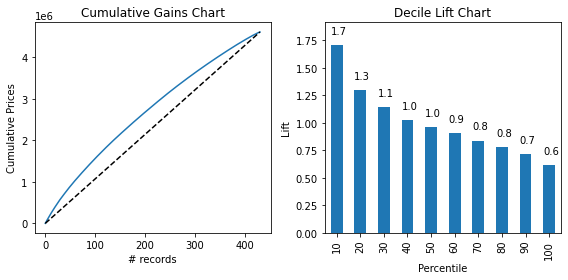

In [51]:
# print performance measures (valid data)
pred_y = pd.Series(car_lmr.predict(valid_data[predictors]))

regression_summary(valid_data[outcome], pred_y)
print("\nr2adj - validation: ", adjusted_r2_score(valid_data[outcome],
                                                  pred_y, car_lmr))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
ax = gains_chart(pred_y.sort_values(ascending=False), ax=axes[0])
ax.set_ylabel("Cumulative Prices")
ax.set_title("Cumulative Gains Chart")

ax = lift_chart(pred_y.sort_values(ascending=False), ax=axes[1])
ax.set_ylabel("Lift")
plt.tight_layout()

plt.show()


Regression statistics

                      Mean Error (ME) : 91.2764
       Root Mean Squared Error (RMSE) : 1271.8760
            Mean Absolute Error (MAE) : 958.7654
          Mean Percentage Error (MPE) : 0.3914
Mean Absolute Percentage Error (MAPE) : 9.6015

r2adj - test:  0.8672175994750433


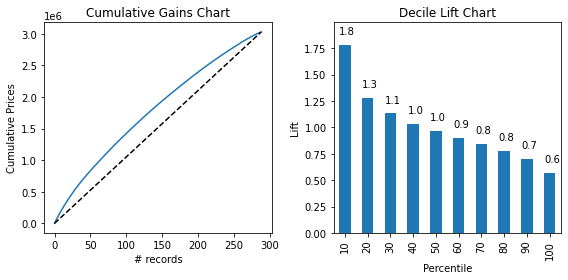

In [52]:
# print performance measures (test data)
pred_y = pd.Series(car_lmr.predict(test_data[predictors]))

regression_summary(test_data[outcome], pred_y)
print("\nr2adj - test: ", adjusted_r2_score(test_data[outcome],
                                                  pred_y, car_lmr))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
ax = gains_chart(pred_y.sort_values(ascending=False), ax=axes[0])
ax.set_ylabel("Cumulative Prices")
ax.set_title("Cumulative Gains Chart")

ax = lift_chart(pred_y.sort_values(ascending=False), ax=axes[1])
ax.set_ylabel("Lift")
plt.tight_layout()